# Model Prototype

### Load Data

In [1]:
# load libraries
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

In [2]:
class DataCleaner():

    def clean_uom_space(self,uom_space_df):
        uom_space_df['Campus Code']=uom_space_df['Campus Code'].astype(str).str.strip()
        uom_space_df['Building Code']=uom_space_df['Building Code'].astype(str).str.strip()
        uom_space_df['Building Name']=uom_space_df['Building Name'].astype(str).str.strip()
        uom_space_df['Room Type']=uom_space_df['Room Type'].astype(str).str.strip()
        uom_space_df['Room Category']=uom_space_df['Room Category'].astype(str).str.strip()
        uom_space_df['Floor Code']=uom_space_df['Floor Code'].astype(str).str.strip()
        uom_space_df['Room Code']=uom_space_df['Room Code'].astype(str).str.strip()
        return uom_space_df

    def clean_rm_category_type(self,rm_category_type_df):
        rm_category_type_df['Room Type']=rm_category_type_df['Room Type'].astype(str).str.strip()
        rm_category_type_df['Room Category']=rm_category_type_df['Room Category'].astype(str).str.strip()
        rm_category_type_df['Room Type Abbreviation']=rm_category_type_df['Room Type Abbreviation'].str.lower().str.strip()
        rm_category_type_df['Description']=rm_category_type_df['Description'].str.lower().str.strip()
        rm_category_type_df['Room Type Definition']=rm_category_type_df['Room Type Definition'].str.lower().str.strip()
        return rm_category_type_df

    def clean_floor_data(self,floor_df):
        floor_df['Building Code'] = floor_df['Building Code'].astype(str).str.strip()
        floor_df['Floor Code'] = floor_df['Floor Code'].astype(str).str.strip()
        floor_df['Floor Name'] = floor_df['Floor Name'].astype(str).str.strip()
        return floor_df

    def clean_em_location(self,em_location_df):
        em_location_df['Floor Code'] = em_location_df['Floor Code'].astype(int)
        em_location_df['Floor Code'] = em_location_df['Floor Code'].astype(str).str.strip()
        return em_location_df

    def clean_av_equipment(self,av_equipment_df):
        av_equipment_df['Room Type'] = av_equipment_df['Room Type'].astype(str).str.strip()
        av_equipment_df['Room Code'] = av_equipment_df['Room Code'].astype(str).str.strip()
        av_equipment_df['Building Code'] = av_equipment_df['Building Code'].astype(str).str.strip()
        av_equipment_df['Campus Code'] = av_equipment_df['Campus Code'].astype(str).str.strip()
        av_equipment_df['Equip. Status'] = av_equipment_df['Equip. Status'].astype(str).str.strip()
        av_equipment_df['Floor Code'] = av_equipment_df['Floor Code'].astype(int).astype(str).str.strip()
        return av_equipment_df

    def clean_timetable_data(self,timetable_df):
        # remove all NaN rows
        timetable_df = timetable_df.dropna(how='all')

        # drop duplicate records
        timetable_df = timetable_df.drop_duplicates()

        # dropping classes whose location is not planned
        timetable_df = timetable_df[timetable_df['Host Key of Allocated Locations'].notna()]

        # dropping classes whose location is online option
        timetable_df = timetable_df[timetable_df['Host Key of Allocated Locations']!='Online option.']

        # dropping classes with off-site location
        timetable_df = timetable_df[timetable_df['Name of Zone of Allocated Locations']!='Off-Site']
        return timetable_df

    def clean_meeting_room_usage(self,meeting_room_usage_df):
        meeting_room_usage_df = meeting_room_usage_df[meeting_room_usage_df['Campus Code'].notna()]
        meeting_room_usage_df = meeting_room_usage_df[meeting_room_usage_df['Building Code'].notna()]
        meeting_room_usage_df = meeting_room_usage_df[meeting_room_usage_df['Floor Code'].notna()]
        meeting_room_usage_df = meeting_room_usage_df[meeting_room_usage_df['Room Code'].notna()]

        meeting_room_usage_df['Campus Code'] = meeting_room_usage_df['Campus Code'].astype(str).str.strip()
        meeting_room_usage_df['Building Code'] = meeting_room_usage_df['Building Code'].astype(str).str.strip()
        meeting_room_usage_df['Building Name'] = meeting_room_usage_df['Building Name'].astype(str).str.strip()
        meeting_room_usage_df['Floor Code'] = meeting_room_usage_df['Floor Code'].astype(int).astype(str).str.strip()
        meeting_room_usage_df['Room Code'] = meeting_room_usage_df['Room Code'].astype(str).str.strip()
        return meeting_room_usage_df

In [3]:
class DataMutator():

    def mutate_em_location(self,em_location_df):
        # mutate room codes
        for idx,row in em_location_df.iterrows():
            if "." in row['Room Code']:
                code = row['Room Code'].split(".")[0]
                em_location_df.at[idx,'Room Code'] = code
        return em_location_df

    def mutate_timetable_data(self,timetable_df):
        building_codes = []
        room_codes = []
        campus_codes = []
        class_duration_minutes = []
        for idx,row in timetable_df.iterrows():
            s = row['Host Key of Allocated Locations'].split('-')
            building_codes.append(s[0])
            room_codes.append(s[1])
            c = row['Name of Allocated Locations'].split('-')[0]
            if c == 'zzzPAR':
                c = 'PAR'
            campus_codes.append(c)
            d = row['Duration as duration']
            class_duration_minutes.append(d.hour * 60 + d.minute)
        timetable_df['Building Code'] = building_codes
        timetable_df['Room Code'] = room_codes
        timetable_df['Campus Code'] = campus_codes
        timetable_df['Class Duration In Minutes'] = class_duration_minutes
        return timetable_df

In [4]:
class DataMerger():

    def get_merged_space_data(self,uom_space_df,rm_category_type_df, floor_df):
        uom_space_df_enhanced = pd.merge(uom_space_df,floor_df,on=['Building Code','Floor Code'])
        print("# Merge - uom_space + floor_data")
        print((uom_space_df.shape, uom_space_df_enhanced.shape))
        print('Unable to merge records:',uom_space_df.shape[0]-uom_space_df_enhanced.shape[0])
        merged_space_data_df = pd.merge(uom_space_df_enhanced,rm_category_type_df,on=['Room Category','Room Type'])
        print("# Merge - enhanced_uom_space + rm_category_type")
        print((uom_space_df_enhanced.shape, merged_space_data_df.shape))
        print('Unable to merge records:',uom_space_df_enhanced.shape[0]-merged_space_data_df.shape[0])
        return merged_space_data_df

    def get_merged_em_location_data(self,em_location_df,merged_space_data_df):
        print("# merge - space_data + em_location")
        merged_em_location_df = pd.merge(em_location_df,merged_space_data_df,on=['Building Code','Floor Code','Room Code'])
        print((em_location_df.shape, merged_em_location_df.shape))
        print('Unable to merge records:',em_location_df.shape[0]-merged_em_location_df.shape[0])
        return merged_em_location_df

    def get_merged_av_equipment_data(self,av_equipment_df,merged_space_data_df):
        print("# merge - space_data + av_equipment")
        merged_av_equipment_df = pd.merge(av_equipment_df,merged_space_data_df,on=['Campus Code','Building Code','Floor Code','Room Code'])
        print((av_equipment_df.shape, merged_av_equipment_df.shape))
        print('Unable to merge records:',av_equipment_df.shape[0]-merged_av_equipment_df.shape[0])
        return merged_av_equipment_df

    def get_merged_timetable_data(self,timetable_df,merged_space_data_df):
        print("# merge - space_data + timetable_data")
        merged_timetable_df = pd.merge(timetable_df,merged_space_data_df,on=['Campus Code','Building Code','Room Code'])
        print((timetable_df.shape, merged_timetable_df.shape))
        print('Unable to merge records:',timetable_df.shape[0]-merged_timetable_df.shape[0])
        return merged_timetable_df

    def get_merged_meeting_room_usage_data(self,meeting_room_usage_df,merged_space_data_df):
        print("# merge - space_data + meeting_room_usage")
        merged_meeting_room_usage_df = pd.merge(meeting_room_usage_df,merged_space_data_df,on=['Campus Code','Building Code','Floor Code','Room Code'])
        print((meeting_room_usage_df.shape, merged_meeting_room_usage_df.shape))
        print('Unable to merge records:',meeting_room_usage_df.shape[0]-merged_meeting_room_usage_df.shape[0])
        return merged_meeting_room_usage_df

In [5]:
class DataProcessor():
    def __init__(self,uom_space_url,rm_category_type_url,
                 em_location_url,av_equipment_url,
                 timetable_2020_url,floor_name_url,
                 meeting_room_usage_url):
        self.uom_space_url = uom_space_url
        self.rm_category_type_url = rm_category_type_url
        self.em_location_url = em_location_url
        self.av_equipment_url = av_equipment_url
        self.timetable_2020_url = timetable_2020_url
        self.floor_name_url = floor_name_url
        self.meeting_room_usage_url = meeting_room_usage_url

    def load_data(self):
        self.uom_space_df = pd.read_excel(uom_space_url)
        self.rm_category_type_df = pd.read_excel(rm_category_type_url)
        self.em_location_df = pd.read_excel(em_location_url)
        self.av_equipment_df = pd.read_excel(av_equipment_url)
        self.timetable_df = pd.read_excel(timetable_2020_url, delim_whitespace=True)
        self.floor_df = pd.read_excel(floor_name_url)
        self.meeting_room_usage_df = pd.read_excel(meeting_room_usage_url)
        print('Data loaded successfully!')
        # data shapes
        print("UOM space shape:"+str(self.uom_space_df.shape))
        print("RM category:"+str(self.rm_category_type_df.shape))
        print("EM location:"+str(self.em_location_df.shape))
        print("AV equipment:"+str(self.av_equipment_df.shape))
        print("2020 timetable:"+str(self.timetable_df.shape))
        print("Floor data shape:"+str(self.floor_df.shape))
        print("Meeting room usage shape:"+str(self.meeting_room_usage_df.shape))

    def get_all_datasets(self):

        print("# clean data")
        _cleaner = DataCleaner()
        self.uom_space_df = _cleaner.clean_uom_space(self.uom_space_df)
        self.rm_category_type_df = _cleaner.clean_rm_category_type(self.rm_category_type_df)
        self.floor_df = _cleaner.clean_floor_data(self.floor_df)
        self.em_location_df = _cleaner.clean_em_location(self.em_location_df)
        self.av_equipment_df = _cleaner.clean_av_equipment(self.av_equipment_df)
        self.timetable_df = _cleaner.clean_timetable_data(self.timetable_df)
        self.meeting_room_usage_df = _cleaner.clean_meeting_room_usage(self.meeting_room_usage_df)

        print("# mutate data")
        _mutator = DataMutator()
        self.em_location_df = _mutator.mutate_em_location(self.em_location_df)
        self.timetable_df = _mutator.mutate_timetable_data(self.timetable_df)

        print("# merge data")
        _merger = DataMerger()
        self.merged_space_data = _merger.get_merged_space_data(self.uom_space_df, self.rm_category_type_df, self.floor_df)
        self.merged_em_location_data = _merger.get_merged_em_location_data(self.em_location_df,self.merged_space_data)
        self.merged_av_equipment_data = _merger.get_merged_av_equipment_data(self.av_equipment_df,self.merged_space_data)
        self.merged_timetable_data = _merger.get_merged_timetable_data(self.timetable_df,self.merged_space_data)
        self.merged_meeting_room_usage_data = _merger.get_merged_meeting_room_usage_data(self.meeting_room_usage_df,self.merged_space_data)

        return self.merged_space_data, self.merged_em_location_data, self.merged_av_equipment_data, self.merged_timetable_data, self.merged_meeting_room_usage_data

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
# local urls
uom_space_url = '/content/drive/My Drive/project-space-optimisation-group-3/project-data/uom-space.xlsx'
rm_category_type_url = '/content/drive/My Drive/project-space-optimisation-group-3/project-data/rm-category-type-cleaned.xlsx'
em_location_url = '/content/drive/My Drive/project-space-optimisation-group-3/project-data/em-location.xlsx'
av_equipment_url = '/content/drive/My Drive/project-space-optimisation-group-3/project-data/av-equipment.xlsx'
timetable_2020_url = '/content/drive/My Drive/project-space-optimisation-group-3/project-data/2020-timetable-v2.xlsx'
floor_name_url = '/content/drive/My Drive/project-space-optimisation-group-3/project-data/fl-name-cleaned.xlsx'
meeting_room_usage_url = '/content/drive/My Drive/project-space-optimisation-group-3/project-data/meeting-room-usage.xlsx'

In [8]:
# load data
_processor = DataProcessor(uom_space_url,rm_category_type_url,em_location_url,av_equipment_url,
                           timetable_2020_url,floor_name_url,meeting_room_usage_url)
_processor.load_data()

Data loaded successfully!
UOM space shape:(22166, 14)
RM category:(209, 5)
EM location:(7709, 4)
AV equipment:(1964, 11)
2020 timetable:(131857, 23)
Floor data shape:(1369, 3)
Meeting room usage shape:(1462, 22)


In [9]:
# get datasets - after cleaning, mutation and merging
space_data, employee_data, av_equipment_data, timetable_data, mr_usage_data = _processor.get_all_datasets()

# clean data
# mutate data
# merge data
# Merge - uom_space + floor_data
((22166, 14), (22166, 15))
Unable to merge records: 0
# Merge - enhanced_uom_space + rm_category_type
((22166, 15), (22166, 18))
Unable to merge records: 0
# merge - space_data + em_location
((7709, 4), (6962, 19))
Unable to merge records: 747
# merge - space_data + av_equipment
((1964, 11), (1646, 25))
Unable to merge records: 318
# merge - space_data + timetable_data
((119419, 27), (116981, 42))
Unable to merge records: 2438
# merge - space_data + meeting_room_usage
((890, 22), (728, 36))
Unable to merge records: 162


In [11]:
class DataExtractor():

    def get_meeting_rooms_data(self,rm_category_type_df,space_data):
        # possible meeting rooms
        possible_rooms = rm_category_type_df[rm_category_type_df['Room Type'].str.contains("601|629")]
        meeting_room_types = possible_rooms['Room Type'].tolist()

        # supply of meeting rooms
        possible_meeting_rooms_df = space_data[space_data['Room Type'].isin(meeting_room_types)]
        return possible_meeting_rooms_df

    def get_toilets_data(self,rm_category_type_df,space_data):
        possible_rooms = rm_category_type_df[rm_category_type_df['Room Type Definition'].str.contains("toilet|washroom")]
        toilet_room_types = possible_rooms['Room Type'].tolist()

        possible_toilets_df = space_data[space_data['Room Type'].isin(toilet_room_types)]
        return possible_toilets_df

In [12]:
_extractor = DataExtractor()
possible_meeting_rooms_data = _extractor.get_meeting_rooms_data(_processor.rm_category_type_df, space_data)
possible_toilets_data = _extractor.get_toilets_data(_processor.rm_category_type_df, space_data)

## Floor based prediction model

In [ ]:
space_data.head(5)

,Campus Code,Building Code,Building Name,Floor Code,Room Code,Room Name,Room Category,Room Type,Room Type Abbreviation_x,Room Capacity,Room Area m²,Room Condition 2018,Department Code,Room Location Code,Floor Name,Room Type Abbreviation_y,Description,Room Type Definition
0,PAR,101,BEAUREPAIRE CENTRE,0,CG01,NaN,6,631,Circ-Department,0.0,80.62,NaN,8490,PAR;101;0;CG01,Ground,circ-department,circulation - department,a corridor allocated to a specific faculty tha...
1,PAR,101,BEAUREPAIRE CENTRE,0,CG03,NaN,6,631,Circ-Department,0.0,14.12,NaN,8490,PAR;101;0;CG03,Ground,circ-department,circulation - department,a corridor allocated to a specific faculty tha...
2,PAR,101,BEAUREPAIRE CENTRE,1,C101,NaN,6,631,Circ-Department,0.0,5.79,NaN,8490,PAR;101;1;C101,Level 1,circ-department,circulation - department,a corridor allocated to a specific faculty tha...
3,PAR,101,BEAUREPAIRE CENTRE,1,C102,NaN,6,631,Circ-Department,0.0,5.77,NaN,8490,PAR;101;1;C102,Level 1,circ-department,circulation - department,a corridor allocated to a specific faculty tha...
4,PAR,101,BEAUREPAIRE CENTRE,1,C103,NaN,6,631,Circ-Department,0.0,23.87,NaN,8490,PAR;101;1;C103,Level 1,circ-department,circulation - department,a corridor allocated to a specific faculty tha...


In [ ]:
space_data.columns

Index(['Campus Code', 'Building Code', 'Building Name', 'Floor Code',
       'Room Code', 'Room Name', 'Room Category', 'Room Type',
       'Room Type Abbreviation_x', 'Room Capacity', 'Room Area m²',
       'Room Condition 2018', 'Department Code', 'Room Location Code',
       'Floor Name', 'Room Type Abbreviation_y', 'Description',
       'Room Type Definition'],
      dtype='object')

In [20]:
# find out the number of meeting rooms with excellent, very good, good condition
import numpy as np
possible_meeting_rooms_data["Good"] = np.where((possible_meeting_rooms_data['Room Condition 2018'] == "Good"), 1, 0)
possible_meeting_rooms_data["Excellent"] = np.where((possible_meeting_rooms_data['Room Condition 2018'] == "Excellent"), 1, 0)
possible_meeting_rooms_data["Very Good"] = np.where((possible_meeting_rooms_data['Room Condition 2018'] == "Very Good"), 1, 0)

In [21]:
building_code = '104'

In [22]:
# alan gilbert building
data_104 = space_data[space_data['Building Code']==building_code]
data_104.shape

(486, 18)

In [23]:
timetable_104 = timetable_data[timetable_data['Building Code'] == building_code]
timetable_104.groupby(by = ['Floor Code','Floor Name'], as_index=False).agg({ 'Class Duration In Minutes':'mean'})

,Floor Code,Floor Name,Class Duration In Minutes
0,0,Ground,73.065855
1,1,Level 1,90.519668


In [24]:
possible_floors_104 = data_104.groupby(by=['Floor Code','Floor Name'],as_index=False).agg({'Room Code':pd.Series.nunique})
possible_floors_104

,Floor Code,Floor Name,Room Code
0,0,Ground,35
1,0.1,Basement 1,19
2,0.5,Ground Mezzanine,2
3,1,Level 1,45
4,2,Level 2,74
5,3,Level 3,38
6,4,Level 4,73
7,5,Level 5,62
8,6,Level 6,63
9,7,Level 7,57


In [25]:
meeting_rooms_104 = possible_meeting_rooms_data[possible_meeting_rooms_data['Building Code']==building_code]
meeting_rooms_104.shape

(33, 21)

In [26]:
room_condition_104 = meeting_rooms_104.groupby(by=['Floor Code','Floor Name','Room Condition 2018'],as_index=False).agg({'Room Code':pd.Series.nunique})

In [ ]:
room_condition_104

,Floor Code,Floor Name,Room Condition 2018,Room Code
0,1,Level 1,Excellent,2
1,2,Level 2,Good,5
2,3,Level 3,Good,1
3,4,Level 4,Excellent,12
4,5,Level 5,Excellent,8
5,6,Level 6,Excellent,3
6,7,Level 7,Excellent,2


In [27]:
meeting_rooms_104.groupby(by = ['Floor Code','Floor Name'], as_index=False).agg({'Good':sum, 'Very Good':sum, 'Excellent':sum,'Room Capacity':sum})

,Floor Code,Floor Name,Good,Very Good,Excellent,Room Capacity
0,1,Level 1,0,0,2,8.0
1,2,Level 2,5,0,0,58.0
2,3,Level 3,1,0,0,6.0
3,4,Level 4,0,0,12,76.0
4,5,Level 5,0,0,8,84.0
5,6,Level 6,0,0,3,16.0
6,7,Level 7,0,0,2,33.0


In [28]:
# props of good condition meeting rooms
meeting_rooms_104_by_floor = meeting_rooms_104.groupby(by = ['Floor Code','Floor Name'], as_index=False).agg({'Good':sum, 'Very Good':sum, 'Excellent':sum,'Room Capacity':sum,'Room Capacity':sum, 'Room Code':pd.Series.nunique})
print(meeting_rooms_104_by_floor)

  Floor Code Floor Name  Good  Very Good  Excellent  Room Capacity  Room Code
0          1    Level 1     0          0          2            8.0          2
1          2    Level 2     5          0          0           58.0          5
2          3    Level 3     1          0          0            6.0          1
3          4    Level 4     0          0         12           76.0         12
4          5    Level 5     0          0          8           84.0          8
5          6    Level 6     0          0          3           16.0          3
6          7    Level 7     0          0          2           33.0          2


In [29]:
meeting_rooms_104_by_floor['Room Code'].sum()

33

In [30]:
meeting_rooms_104_by_floor[meeting_rooms_104_by_floor['Floor Code']=='1']

,Floor Code,Floor Name,Good,Very Good,Excellent,Room Capacity,Room Code
0,1,Level 1,0,0,2,8.0,2


In [31]:
em_104 = employee_data[employee_data['Building Code']==building_code]
em_104.shape

(329, 19)

In [32]:
em_104_by_floor = em_104.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({'Employee Sequential ID':pd.Series.nunique})
em_104_by_floor['props']  = em_104_by_floor['Employee Sequential ID']/em_104.shape[0]
em_104_by_floor

,Floor Code,Floor Name,Employee Sequential ID,props
0,0,Ground,10,0.030395
1,1,Level 1,29,0.088146
2,2,Level 2,61,0.185410
3,4,Level 4,68,0.206687
4,5,Level 5,40,0.121581
5,6,Level 6,76,0.231003
6,7,Level 7,45,0.136778


In [33]:
av_equipment_data.columns

Index(['Equipment Code', 'Equipment Standard', 'Manufacturer', 'Equip. Status',
       'Building Code', 'Floor Code', 'Room Code', 'Campus Code',
       'Room Type_x', 'Room Type Abbreviation', 'Room Category_x',
       'Building Name', 'Room Name', 'Room Category_y', 'Room Type_y',
       'Room Type Abbreviation_x', 'Room Capacity', 'Room Area m²',
       'Room Condition 2018', 'Department Code', 'Room Location Code',
       'Floor Name', 'Room Type Abbreviation_y', 'Description',
       'Room Type Definition'],
      dtype='object')

In [34]:
# get equipment data for meeting rooms
meetingroom_equipment = av_equipment_data[av_equipment_data['Room Type_x'].str.contains("601|629")]
# find out number of equip. in use
meetingroom_equipment["Usable Equip."] = np.where((meetingroom_equipment['Equip. Status'] == "In service"), 1, 0)

equipment_104 = meetingroom_equipment[meetingroom_equipment['Building Code']==building_code]
equipment_by_floor = equipment_104.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({'Usable Equip.':sum})

In [ ]:
equipment_104.columns

Index(['Equipment Code', 'Equipment Standard', 'Manufacturer', 'Equip. Status',
       'Building Code', 'Floor Code', 'Room Code', 'Campus Code',
       'Room Type_x', 'Room Type Abbreviation', 'Room Category_x',
       'Building Name', 'Room Name', 'Room Category_y', 'Room Type_y',
       'Room Type Abbreviation_x', 'Room Capacity', 'Room Area m²',
       'Room Condition 2018', 'Department Code', 'Room Location Code',
       'Floor Name', 'Room Type Abbreviation_y', 'Description',
       'Room Type Definition', 'Usable Equip.'],
      dtype='object')

In [ ]:
equipment_by_floor = equipment_104.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({'Usable Equip.':sum})

equipment_by_floor["props"] = equipment_by_floor['Usable Equip.']/equipment_104.shape[0]

In [ ]:
equipment_by_floor

,Floor Code,Floor Name,Usable Equip.,props
0,4,Level 4,1,0.5
1,6,Level 6,1,0.5


In [ ]:
 mr_usage_data.columns

Index(['From', 'To', 'RoomEmail', 'Campus Code', 'Building Code',
       'Building Name_x', 'Floor Code', 'Room Code', 'RoomName', 'Meetings',
       'Duration', 'AvgDuration', 'TotAttendees', 'AvgAttendees',
       'ReqAttendees', 'OptAttendees', 'AMtotal', 'AMperc', 'PMtotal',
       'PMperc', 'RecTotal', 'RecPerc', 'Building Name_y', 'Room Name',
       'Room Category', 'Room Type', 'Room Type Abbreviation_x',
       'Room Capacity', 'Room Area m²', 'Room Condition 2018',
       'Department Code', 'Room Location Code', 'Floor Name',
       'Room Type Abbreviation_y', 'Description', 'Room Type Definition'],
      dtype='object')

In [35]:
usage_104 = mr_usage_data[mr_usage_data['Building Code']==building_code]

In [36]:
# number of meeting held in each floor
count_df = usage_104.groupby(by=['Floor Code','Floor Name'],as_index=False).size().reset_index(name='Meeting_Counts')

In [ ]:
count_df

,Floor Code,Floor Name,Meeting_Counts
0,1,Level 1,2
1,2,Level 2,4
2,3,Level 3,4
3,4,Level 4,11
4,5,Level 5,10
5,6,Level 6,3
6,7,Level 7,6


In [37]:
duration_df = usage_104.groupby(by=['Floor Code','Floor Name'],as_index=False).agg({'AvgDuration':'mean'})

In [38]:
pd.merge(count_df, duration_df, on='Floor Code', how='outer')

,Floor Code,Floor Name_x,Meeting_Counts,Floor Name_y,AvgDuration
0,1,Level 1,2,Level 1,63.500000
1,2,Level 2,4,Level 2,107.250000
2,3,Level 3,4,Level 3,141.750000
3,4,Level 4,11,Level 4,41.727273
4,5,Level 5,10,Level 5,51.400000
5,6,Level 6,3,Level 6,63.000000
6,7,Level 7,6,Level 7,286.000000


In [13]:
import numpy as np
from scipy.special import softmax
from heapq import nlargest
from random import randint
import heapq

class PriorityQueue:
    """
      Implements a priority queue data structure. Each inserted item
      has a priority associated with it and the client is usually interested
      in quick retrieval of the lowest-priority item in the queue. This
      data structure allows O(1) access to the lowest-priority item.
    """
    def  __init__(self):
        self.heap = []
        self.count = 0

    def push(self, item, priority):
        entry = (priority, self.count, item)
        heapq.heappush(self.heap, entry)
        self.count += 1

    def pop(self):
        (_, _, item) = heapq.heappop(self.heap)
        return item

    def isEmpty(self):
        return len(self.heap) == 0

    def update(self, item, priority):
        # If item already in priority queue with higher priority, update its priority and rebuild the heap.
        # If item already in priority queue with equal or lower priority, do nothing.
        # If item not in priority queue, do the same thing as self.push.
        for index, (p, c, i) in enumerate(self.heap):
            if i == item:
                if p <= priority:
                    break
                del self.heap[index]
                self.heap.append((priority, c, item))
                heapq.heapify(self.heap)
                break
        else:
            self.push(item, priority)

def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


In [18]:
equipment_104 = meetingroom_equipment[meetingroom_equipment['Building Code']==building_code]
equipment_by_floor = equipment_104.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({'Usable Equip.':sum})
equipment_by_floor

NameError: ignored

In [ ]:
def find_MR_algorithm(current_building, floor_position, factors, k, objective):
    B = 1
    
    meeting_rooms = possible_meeting_rooms_data[possible_meeting_rooms_data['Building Code']==current_building]
    # equipment data
    equipment = meetingroom_equipment[meetingroom_equipment['Building Code']==building_code]
    equipment_by_floor = equipment.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({'Usable Equip.':sum})
    equipment_by_floor['Floor Code'] = equipment_by_floor['Floor Code'].astype(float)

    good = meeting_rooms['Room Condition 2018'] == 'Good'
    very_good = meeting_rooms['Room Condition 2018'] == 'Very Good'
    excellent = meeting_rooms['Room Condition 2018'] == 'Excellent' 
    if "ROOM_CONDITION" in factors:
        condition = factors["ROOM_CONDITION"].lower()
        if condition == 'good':
            available_meeting_rooms = meeting_rooms[good | very_good | excellent]
      
        elif condition == 'very good':
            available_meeting_rooms = meeting_rooms[very_good | excellent]
      
        elif condition == 'excellent':
            available_meeting_rooms = meeting_rooms[excellent]
    
    else: 
        available_meeting_rooms = meeting_rooms[good | very_good | excellent]
    available_meeting_rooms_by_floor = available_meeting_rooms.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({"Room Capacity":sum})

    meeting_rooms_by_floor = meeting_rooms.groupby(by=['Floor Code','Floor Name'],as_index=False).agg({"Room Code": 'count', "Room Capacity":sum})
    
    possible_floors = meeting_rooms.groupby(by=['Floor Code','Floor Name'],as_index=False).agg({'Room Code':pd.Series.nunique})
    possible_floors['Floor Code'] = possible_floors['Floor Code'].astype(float)
  
    # employee data
    employee = employee_data[employee_data['Building Code']==current_building]
    employee_by_floor = employee.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({'Employee Sequential ID':'count'})
    employee_by_floor['Floor Code'] = employee_by_floor['Floor Code'].astype(float) 

    # create the graph
    idx_of_position = floor_position
    available_meeting_rooms_by_floor['Floor Code'] = available_meeting_rooms_by_floor['Floor Code'].astype(float)
    graph = []
    for floors in available_meeting_rooms_by_floor['Floor Code']:
      if floors != idx_of_position:
        graph.append((idx_of_position, floors))

# distance between floors - cost function  
    def get_cost(node1, node2):
        distance = abs(node1 - node2)
        return distance
    
    def get_delta():
        return randint(1,99)

    def get_reward(node, objective, factors):  
        # meeting_rooms that satisfy required condition

        total_meeting_rooms = available_meeting_rooms_by_floor['Room Capacity'].sum() 
      
        total_employees = employee_by_floor['Employee Sequential ID'].sum()

        
        if total_meeting_rooms == 0:
            print ("No Suitable meeting_rooms In This Building")        
    
        reward_df = pd.merge(available_meeting_rooms_by_floor, employee_by_floor, how = 'left', on = ['Floor Code','Floor Name'])
        reward_df = pd.merge(reward_df, equipment_by_floor, how = 'left', on = ['Floor Code','Floor Name'])
        reward_df = reward_df.fillna(0)
        reward_df['Floor Code'] = reward_df['Floor Code'].astype(float)
        
        reward_df = reward_df[(reward_df['Floor Code']) == float(node)]
      
        reward_df['employee_prop'] = reward_df['Employee Sequential ID']/total_employees
        
        
        
        # COVID 
        if "COVID_LOCKDOWN" in factors:
            situation = factors["COVID_LOCKDOWN"].lower()
            if situation == "high":
            # demand is 0
                demand = 0          
            elif situation == "medium":
            # demand is 25%
                demand = reward_df['employee_prop'] * 0.25         
            else:
            # demand is 50%
                demand = reward_df['employee_prop'] * 0.5         
        else:
            demand = reward_df['employee_prop']

        # Equipment
        if 'WITH_EQUIPMENT' in factors:
            use_equipment = factors['WITH_EQUIPMENT'].lower()
            if use_equipment == 'yes':
                reward_df["Room Capacity"] += reward_df['Usable Equip.']
     
        reward_df['mr_prop'] = reward_df["Room Capacity"]/total_meeting_rooms

        if float(demand) == 0:
            reward = float(reward_df['mr_prop'])      
        else:
            reward = float(reward_df['mr_prop']/(demand))    
        return reward

    # <reward, node>
    budget_nodes_queue = PriorityQueue()
    best_k = []
    for node in graph:
        # sample a node
        v_s, v_i = node
        cost = get_cost(v_s, v_i)
        reward = get_reward(v_i, objective, factors)
        delta = get_delta()
        if cost <= B + delta:
            priority = -1 * reward
            budget_nodes_queue.push((reward, cost, v_i), priority)
            
    # get k-optimal nodes
    extracted_k = 0
    while not budget_nodes_queue.isEmpty():
        if extracted_k >= k:
            break
        best_k.append(budget_nodes_queue.pop())
        extracted_k += 1

    return best_k

In [ ]:
find_MR_algorithm(current_building = '104', floor_position = 1, factors = {}, k = 3, objective = 0)

[(2.4587188612099644, 4.0, 5.0),
 (1.308561858907264, 3.0, 4.0),
 (1.1132372673706319, 1.0, 2.0)]

In [ ]:
def find_toilet_algorithm(current_building, floor_position, factors, k, objective):
    B = 1
    """
    Find the most optimal nearest toilet

    Parameters:
    current_building 
    floor_position - current floor 
    factors = {'ROOM_CONDITION': , 'COVID_LOCKDOWN': }
    k - required number 
    """
    # get available floors within the same building
    toilets = possible_toilets_data[possible_toilets_data['Building Code']==current_building]

    good = toilets['Room Condition 2018'] == 'Good'
    very_good = toilets['Room Condition 2018'] == 'Very Good'
    excellent = toilets['Room Condition 2018'] == 'Excellent' 
    if "ROOM_CONDITION" in factors:
      condition = factors["ROOM_CONDITION"].lower()
      if condition == 'good':
        available_toilets = toilets[good | very_good | excellent]
      elif condition == 'very good':
        available_toilets = toilets[very_good | excellent]
      elif condition == 'excellent':
        available_toilets = toilets[excellent]
    else: 
      available_toilets = toilets[good | very_good | excellent]
      
    available_toilets_by_floor = available_toilets.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({"Room Capacity":sum})
         
    # student data
    stud = timetable_data[timetable_data['Building Code']==current_building]
    stud_by_floor = stud.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({'Planned Size':sum, 'Class Duration In Minutes':'mean'})
    stud_by_floor['Floor Code'] = stud_by_floor['Floor Code'].astype(float)

    # create the graph
    idx_of_position = floor_position
    available_toilets_by_floor['Floor Code'] = available_toilets_by_floor['Floor Code'].astype(float)
    graph = []
    for floors in available_toilets_by_floor['Floor Code']:
      if floors != idx_of_position:
        graph.append((idx_of_position, floors))

    # distance between floors - cost function  
    def get_cost(node1, node2):
      distance = abs(node1 - node2)
      return distance
    
    def get_delta():
        return randint(1,99)
        
    def get_reward(node, objective, factors):  
      # toilets that satisfy required condition
      
      total_toilets = available_toilets_by_floor['Room Capacity'].sum() 
      
      total_students = stud_by_floor['Planned Size'].sum()

      total_class = stud_by_floor['Class Duration In Minutes'].sum()

      if total_toilets == 0:
        print ("No Suitable Toilets In This Building")        
    
      reward_df = pd.merge(available_toilets_by_floor, stud_by_floor, how = 'left', on = ['Floor Code','Floor Name'] )
      reward_df = reward_df.fillna(0)
      reward_df['Floor Code'] = reward_df['Floor Code'].astype(float)
      reward_df = reward_df[(reward_df['Floor Code']) == float(node)]
      
      reward_df['stu_prop'] = reward_df['Planned Size']/total_students
      reward_df['to_prop'] = reward_df["Room Capacity"]/total_toilets
      reward_df['class_prop'] = reward_df['Class Duration In Minutes']/total_class
      # COVID 
      if "COVID_LOCKDOWN" in factors:
        situation = factors["COVID_LOCKDOWN"].lower()
        if situation == "high":
        # demand is 0
          demand = 0          
        elif situation == "medium":
        # demand is 25%
          demand = reward_df['stu_prop'] * 0.25         
        else:
        # demand is 50%
          demand = reward_df['stu_prop'] * 0.5         
      else:
          demand = reward_df['stu_prop']
            
      if float(demand) == 0:
        reward = float(reward_df['to_prop'])      
      else:
        reward = float(reward_df['to_prop']/(demand + reward_df['class_prop']))    
        
      return reward

    # <reward, node>
    budget_nodes_queue = PriorityQueue()
    best_k = []
    for node in graph:
        # sample a node
        v_s, v_i = node
        cost = get_cost(v_s, v_i)
        reward = get_reward(v_i, objective, factors)
        delta = get_delta()
        if cost <= B + delta:
            priority = -1 * reward
            budget_nodes_queue.push((reward, cost, v_i), priority)
            
    # get k-optimal nodes
    extracted_k = 0
    while not budget_nodes_queue.isEmpty():
        if extracted_k >= k:
            break
        best_k.append(budget_nodes_queue.pop())
        extracted_k += 1

    return best_k

In [ ]:
find_toilet_algorithm(current_building = '104', floor_position = 1, factors = {}, k = 3, objective = 0)

[(0.21108576370407026, 1.0, 0.0),
 (0.10752688172043011, 1.0, 2.0),
 (0.10752688172043011, 2.0, 3.0)]

In [ ]:
def get_floor(current_building, floor_position, factors, k, objective):
    if str(objective) == '0':
      result = find_MR_algorithm(current_building, floor_position, factors, k, objective)
    elif str(objective) == '1':
      result = find_toilet_algorithm(current_building, floor_position, factors, k, objective)
    else:
      result = find_MR_algorithm(current_building, floor_position, factors, k, objective), find_toilet_algorithm(current_building, floor_position, factors, k, objective)
    return result


In [ ]:
get_floor(current_building = '104', floor_position = 1, factors = {'ROOM_CONDITION': 'excellent'}, k = 3, objective = 0)

[(3.1838709677419352, 4.0, 5.0),
 (1.6944971537001896, 3.0, 4.0),
 (1.1118279569892475, 6.0, 7.0)]

In [56]:
def find_floor_algorithm(current_building, floor_position, factors, k, objective):
  B = 1
  if objective == 1:

    toilets = possible_toilets_data[possible_toilets_data['Building Code']==current_building]

    good = toilets['Room Condition 2018'] == 'Good'
    very_good = toilets['Room Condition 2018'] == 'Very Good'
    excellent = toilets['Room Condition 2018'] == 'Excellent' 
    if "ROOM_CONDITION" in factors:
      condition = factors["ROOM_CONDITION"].lower()
      if condition == 'good':
        available_toilets = toilets[good | very_good | excellent]
      elif condition == 'very good':
        available_toilets = toilets[very_good | excellent]
      elif condition == 'excellent':
        available_toilets = toilets[excellent]
    else: 
        available_toilets = toilets[good | very_good | excellent]
      
    available_toilets_by_floor = available_toilets.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({"Room Capacity":sum})
         
      # student data
    stud = timetable_data[timetable_data['Building Code']==current_building]
    stud_by_floor = stud.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({'Planned Size':sum, 'Class Duration In Minutes':'mean'})
    stud_by_floor['Floor Code'] = stud_by_floor['Floor Code'].astype(float)

    # create the graph
    idx_of_position = floor_position
    available_toilets_by_floor['Floor Code'] = available_toilets_by_floor['Floor Code'].astype(float)
    graph = []
    for floors in available_toilets_by_floor['Floor Code']:
      if floors != idx_of_position:
        graph.append((idx_of_position, floors))
    
  else: 
      meeting_rooms = possible_meeting_rooms_data[possible_meeting_rooms_data['Building Code']==current_building]
      # equipment data
      equipment = meetingroom_equipment[meetingroom_equipment['Building Code']==building_code]
      equipment_by_floor = equipment.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({'Usable Equip.':sum})
      equipment_by_floor['Floor Code'] = equipment_by_floor['Floor Code'].astype(float)

      good = meeting_rooms['Room Condition 2018'] == 'Good'
      very_good = meeting_rooms['Room Condition 2018'] == 'Very Good'
      excellent = meeting_rooms['Room Condition 2018'] == 'Excellent' 
      if "ROOM_CONDITION" in factors:
          condition = factors["ROOM_CONDITION"].lower()
          if condition == 'good':
              available_meeting_rooms = meeting_rooms[good | very_good | excellent]
      
          elif condition == 'very good':
              available_meeting_rooms = meeting_rooms[very_good | excellent]
      
          elif condition == 'excellent':
              available_meeting_rooms = meeting_rooms[excellent]
    
      else: 
          available_meeting_rooms = meeting_rooms[good | very_good | excellent]
      available_meeting_rooms_by_floor = available_meeting_rooms.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({"Room Capacity":sum})

      meeting_rooms_by_floor = meeting_rooms.groupby(by=['Floor Code','Floor Name'],as_index=False).agg({"Room Code": 'count', "Room Capacity":sum})
    
      possible_floors = meeting_rooms.groupby(by=['Floor Code','Floor Name'],as_index=False).agg({'Room Code':pd.Series.nunique})
      possible_floors['Floor Code'] = possible_floors['Floor Code'].astype(float)
  
    # employee data
      employee = employee_data[employee_data['Building Code']==current_building]
      employee_by_floor = employee.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({'Employee Sequential ID':'count'})
      employee_by_floor['Floor Code'] = employee_by_floor['Floor Code'].astype(float) 

    # create the graph
      idx_of_position = floor_position
      available_meeting_rooms_by_floor['Floor Code'] = available_meeting_rooms_by_floor['Floor Code'].astype(float)
      graph = []
      for floors in available_meeting_rooms_by_floor['Floor Code']:
        if floors != idx_of_position:
          graph.append((idx_of_position, floors))
      
  def get_reward(node, objective, factors):
      if objective == 0:
        total_meeting_rooms = available_meeting_rooms_by_floor['Room Capacity'].sum() 
        total_employees = employee_by_floor['Employee Sequential ID'].sum()
        if total_meeting_rooms == 0:
            print ("No Suitable meeting_rooms In This Building")        
        reward_df = pd.merge(available_meeting_rooms_by_floor, employee_by_floor, how = 'left', on = ['Floor Code','Floor Name'])
        reward_df = pd.merge(reward_df, equipment_by_floor, how = 'left', on = ['Floor Code','Floor Name'])
        reward_df = reward_df.fillna(0)
        reward_df['Floor Code'] = reward_df['Floor Code'].astype(float)
        
        reward_df = reward_df[(reward_df['Floor Code']) == float(node)]
      
        reward_df['employee_prop'] = reward_df['Employee Sequential ID']/total_employees
        # COVID 
        if "COVID_LOCKDOWN" in factors:
            situation = factors["COVID_LOCKDOWN"].lower()
            if situation == "high":
            # demand is 0
                demand = 0          
            elif situation == "medium":
            # demand is 25%
                demand = reward_df['employee_prop'] * 0.25         
            else:
            # demand is 50%
                demand = reward_df['employee_prop'] * 0.5         
        else:
            demand = reward_df['employee_prop']

        # Equipment
        if 'WITH_EQUIPMENT' in factors:
            use_equipment = factors['WITH_EQUIPMENT'].lower()
            if use_equipment == 'yes':
                reward_df["Room Capacity"] += reward_df['Usable Equip.']
     
        reward_df['mr_prop'] = reward_df["Room Capacity"]/total_meeting_rooms

        if float(demand) == 0:
            reward = float(reward_df['mr_prop'])      
        else:
            reward = float(reward_df['mr_prop']/(demand))    
        return reward
        
      elif objective == 1:
        available_toilets_by_floor = available_toilets.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({"Room Capacity":sum})

        if "REQUIRED_CAPACITY" in factors:
          min_capacity = factors["COVID_LOCKDOWN"]
          available_toilets_by_floor = available_toilets_by_floor[available_toilets_by_floor["Room Capacity"] >= min_capacity]

        total_toilets = available_toilets_by_floor['Room Capacity'].sum() 
        total_students = stud_by_floor['Planned Size'].sum()
        total_class = stud_by_floor['Class Duration In Minutes'].sum()
        if total_toilets == 0:
          print ("No Suitable Toilets In This Building")        
        
        available_toilets_by_floor['Floor Code'] = available_toilets_by_floor['Floor Code'].astype(float)
        reward_df = pd.merge(available_toilets_by_floor, stud_by_floor, how = 'left', on = ['Floor Code','Floor Name'] )
        reward_df = reward_df.fillna(0)
        reward_df['Floor Code'] = reward_df['Floor Code'].astype(float)
        reward_df = reward_df[(reward_df['Floor Code']) == float(node)]
        reward_df['stu_prop'] = reward_df['Planned Size']/total_students
        reward_df['to_prop'] = reward_df["Room Capacity"]/total_toilets
        reward_df['class_prop'] = reward_df['Class Duration In Minutes']/total_class
        # COVID 
        if "COVID_LOCKDOWN" in factors:
          situation = factors["COVID_LOCKDOWN"].lower()
          if situation == "high":
        # demand is 0
            demand = 0          
          elif situation == "medium":
        # demand is 25%
            demand = reward_df['stu_prop'] * 0.25         
          else:
        # demand is 50%
            demand = reward_df['stu_prop'] * 0.5         
        else:
            demand = reward_df['stu_prop']
        if float(demand) == 0:
          reward = float(reward_df['to_prop'])      
        else:
          reward = float(reward_df['to_prop']/(demand + reward_df['class_prop']))    
        return reward
      else:
          print('Objective must be 1 or 2')


 # distance between floors - cost function  
  def get_cost(node1, node2):
      distance = abs(node1 - node2)
      return distance
    
  def get_delta():
      return randint(1,99)

    # <reward, node>
  budget_nodes_queue = PriorityQueue()
  best_k = []
  df = pd.DataFrame()
  cost_1 = []
  reward_1 = []
  for node in graph:
        # sample a node
      v_s, v_i = node
      cost_1.append(get_cost(v_s, v_i))
      reward_1.append(get_reward(v_i, objective, factors))
      cost = get_cost(v_s, v_i)
      reward = get_reward(v_i, objective, factors)
      delta = get_delta()
      if cost <= B + delta:
          priority = -1 * reward
          budget_nodes_queue.push((reward, cost, v_i), priority)
  df = pd.DataFrame()
  df['COST']= cost_1
  df['REWARD'] = reward_1 
      
    # get k-optimal nodes
  extracted_k = 0
  while not budget_nodes_queue.isEmpty():
      if extracted_k >= k:
          break
      best_k.append(budget_nodes_queue.pop())
      extracted_k += 1

  return best_k,df

In [86]:
a,b = find_floor_algorithm(current_building = '104', floor_position = 1, factors = {
    'ROOM_CONDITION':'good',
    'COVID_LOCKDOWN' : 'medium'
}, k = 3, objective = 1)

In [84]:
from numpy import unique
from numpy import where
import numpy as np
from sklearn.cluster import KMeans

def KMEANS(data,show_plot):
    X = data.to_numpy()
    model = KMeans(n_clusters=2,init='k-means++')
    model.fit(X)
    yhat = model.fit_predict(X)
    clusters = unique(yhat)
    get_floor(model,X)
    if show_plot :
        for cluster in clusters:
            row_ix = where(yhat == cluster)
            plt.scatter(X[row_ix, 0], X[row_ix, 1])
        plt.title('KMEANS')
        plt.legend(clusters)
        plt.show()
    else:
        pass

def silhouette(data):
  wcss = []
  for i in range(1,8):
      kmeans = KMeans(n_clusters=i)
      kmeans.fit(data)
      wcss.append(kmeans.inertia_)
  plt.plot(range(1, 8), wcss)
  plt.title('Elbow Method')
  plt.xlabel('Number of clusters')
  plt.ylabel('WCSS')
  plt.show()


def get_floor(model,data):
    cluster_info = {}
    points = {index: np.where(model.labels_ == index)[0] for index in range(model.n_clusters)}
    for index,key in enumerate(points):
        x  = [] 
        y = []
        for index,value in enumerate(points[key]):
            x.append(data[value,0])
            y.append(data[value,1])
      
        cluster_info[key] = {
            'ymin':np.round(min(y),4),
            'ymax':np.round(max(y),4),
            'xmin':np.round(min(x),4),
            'xmax':np.round(max(x),4),
            'avg' :np.average(y)
        }
    print(cluster_info)
    avg = -9999
    cluster = 9999
    for index,key in enumerate(cluster_info):
        if cluster_info[key]['avg'] > avg:
          avg = cluster_info[key]['avg']
          cluster = key
    if (cluster == 9999):
        pass
    else:
        min_distance = cluster_info[cluster]['xmin']
        max_distance = cluster_info[cluster]['xmin']+100
        max_reward = -99
        delta = -99
        for index,value in enumerate(points[cluster]):
            if data[value,0] <= max_distance and data[value,1] > max_reward:
                max_reward = data[value,1]
                delta = data[value,0] - min_distance
                print(data[value,0])
        print('delta',delta)


{0: {'ymin': 0.0108, 'ymax': 0.3193, 'xmin': 0.9, 'xmax': 3.0, 'avg': 0.13053427720587307}, 1: {'ymin': 0.1075, 'ymax': 0.1075, 'xmin': 4.0, 'xmax': 6.0, 'avg': 0.10752688172043011}}
1.0
delta 0.09999999999999998


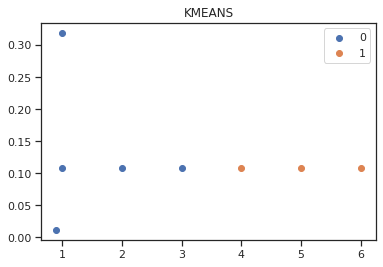

In [87]:
KMEANS(b,True)